Found 5 cover images.
Found 5 watermark images.
Cover 1: All watermarks in one row


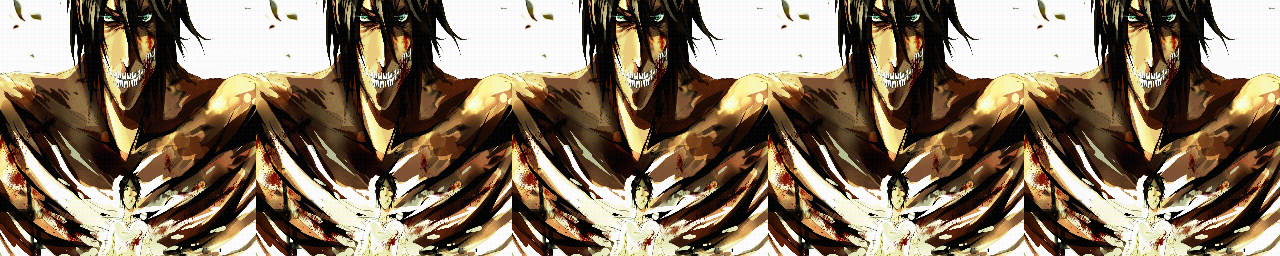

Cover 2: All watermarks in one row


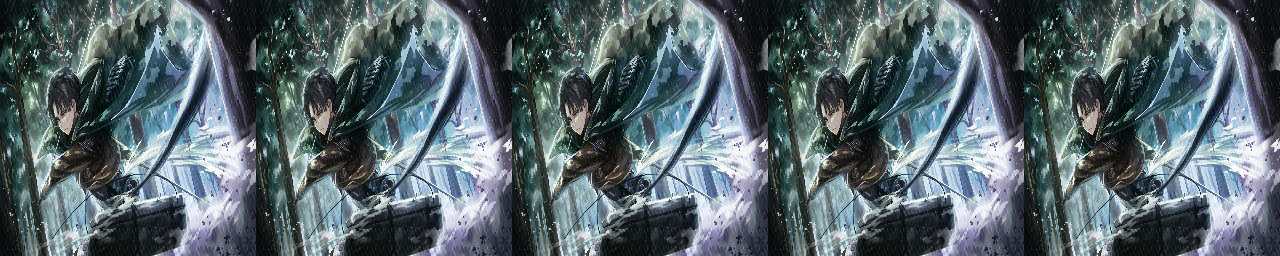

Cover 3: All watermarks in one row


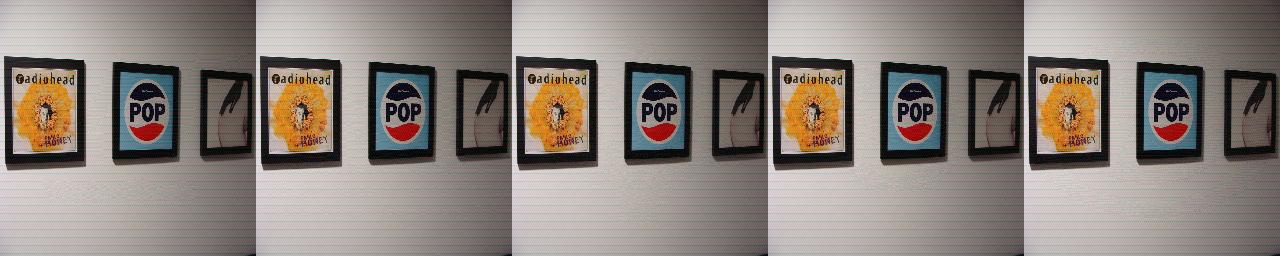

Cover 4: All watermarks in one row


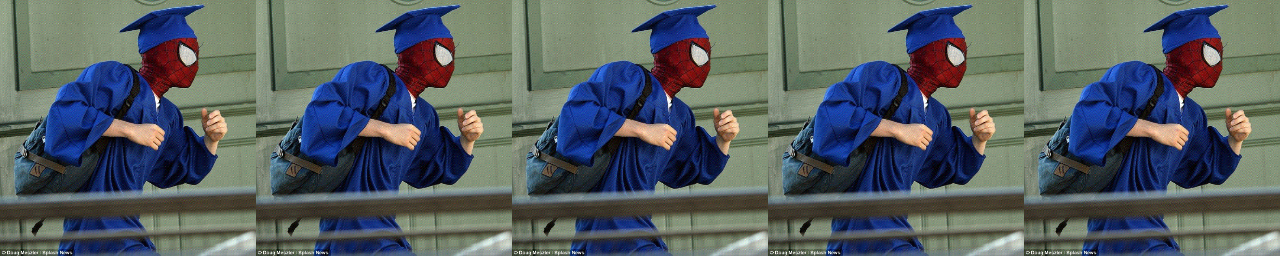

Cover 5: All watermarks in one row


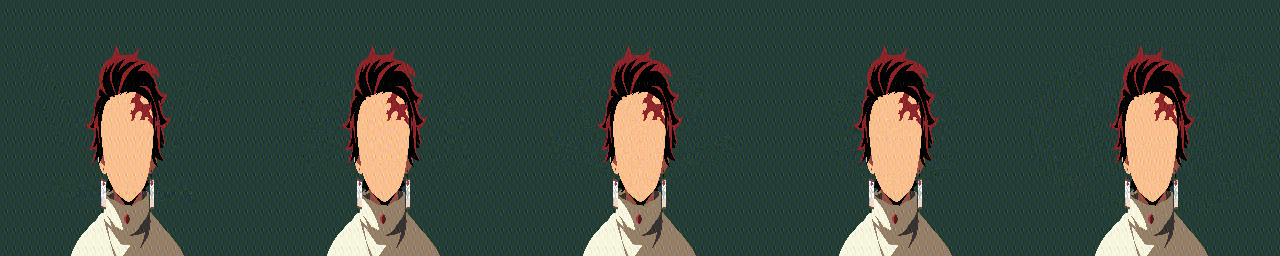

In [ ]:
# @title watermark generation (Data-set generation)
# ================================
# BATCH EMBEDDING DATASET CREATOR
# ================================

import cv2, os, numpy as np
from google.colab.patches import cv2_imshow
import shutil

# -------------------------------
# SETTINGS
# -------------------------------
BLOCK = 8
STRENGTH = 30
POS_R = [(1,2),(1,3),(2,1),(2,2),(2,3),(3,1),(3,2),(3,3)]
POS_G = [(1,4),(1,5),(2,4),(2,5),(3,4),(3,5),(4,3),(4,4)]
POS_B = [(4,2),(4,3),(4,5),(5,2),(5,3),(5,4),(5,5),(6,3)]

covers_dir = "/content/covers/"
wm_dir     = "/content/watermarks/"
output_dir = "/content/watermarked_dataset/"

os.makedirs(output_dir, exist_ok=True)

def clear_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)   # delete entire folder
    os.makedirs(path, exist_ok=True)  # recreate empty folder


def embed_single(cover, wm):
    h, w = cover.shape[:2]

    # auto-resize cover to multiple of 8
    new_h = (h // BLOCK) * BLOCK
    new_w = (w // BLOCK) * BLOCK
    cover = cv2.resize(cover, (new_w, new_h), interpolation=cv2.INTER_AREA)
    h, w = new_h, new_w

    blocks_h = h // BLOCK
    blocks_w = w // BLOCK

    wm_small = cv2.resize(wm, (blocks_w, blocks_h), interpolation=cv2.INTER_AREA)
    if wm_small.ndim == 2:
        wm_small = cv2.cvtColor(wm_small, cv2.COLOR_GRAY2BGR)

    wm_small = wm_small.astype(np.uint8)
    watermarked = cover.copy().astype(np.float32)

    # embedding loop (same as your final code)
    for by in range(blocks_h):
        for bx in range(blocks_w):
            y0 = by * BLOCK
            x0 = bx * BLOCK
            for ch, pos_list in enumerate((POS_R, POS_G, POS_B)):
                block = cover[y0:y0+BLOCK, x0:x0+BLOCK, ch].astype(np.float32)
                d = cv2.dct(block)
                pixel = wm_small[by, bx, ch]
                for bit_i, (r,c) in enumerate(pos_list):
                    bit = (pixel >> (7 - bit_i)) & 1
                    d[r, c] += STRENGTH if bit == 1 else -STRENGTH
                watermarked[y0:y0+BLOCK, x0:x0+BLOCK, ch] = cv2.idct(d)

    return np.clip(watermarked, 0, 255).astype(np.uint8)

# -------------------------------
# RUN BATCH EMBEDDING
# -------------------------------

cover_files = sorted([f for f in os.listdir(covers_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
wm_files    = sorted([f for f in os.listdir(wm_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])

print(f"Found {len(cover_files)} cover images.")
print(f"Found {len(wm_files)} watermark images.")
# CLEAN OLD DATASET OUTPUT
clear_folder("/content/watermarked_dataset/")
count = 0

row_images = []

for ci, cover_name in enumerate(cover_files):
    cover_img = cv2.imread(os.path.join(covers_dir, cover_name))

    row_images = []  # reset row for this cover

    for wi, wm_name in enumerate(wm_files):
        wm_img = cv2.imread(os.path.join(wm_dir, wm_name))

        out = embed_single(cover_img, wm_img)
        out_name = f"cover{ci+1:02d}_wm{wi+1:02d}.png"

        # Resize each watermarked output to same size
        out_small = cv2.resize(out, (256, 256))

        # Add to row list
        row_images.append(out_small)

        # Save output
        cv2.imwrite(os.path.join(output_dir, out_name), out)
        count += 1

    # After processing all watermarks for this cover → show ONE ROW
    combined_row = np.hstack(row_images)
    print(f"Cover {ci+1}: All watermarks in one row")
    cv2_imshow(combined_row)



Extracting 25 watermarked images...

Cover 1: Extracted watermarks in one row


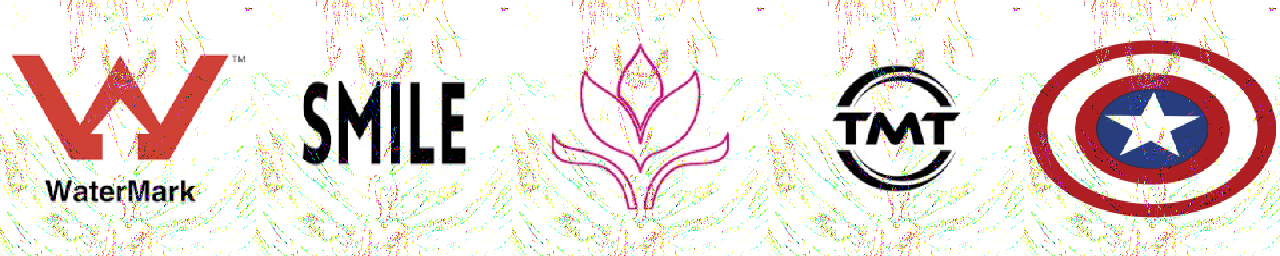


Cover 2: Extracted watermarks in one row


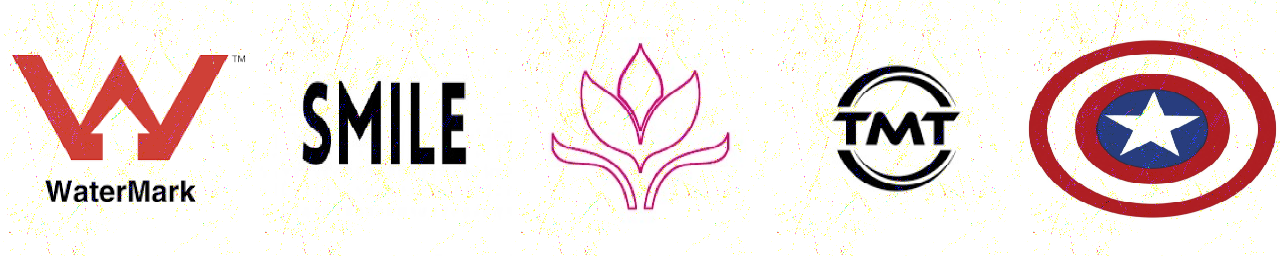


Cover 3: Extracted watermarks in one row


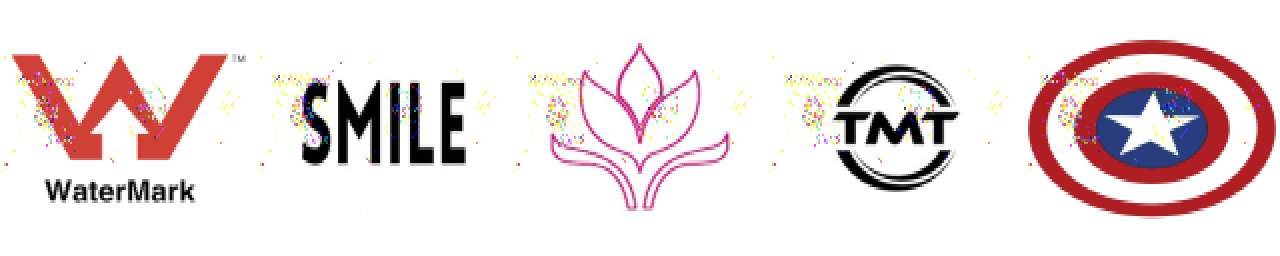


Cover 4: Extracted watermarks in one row


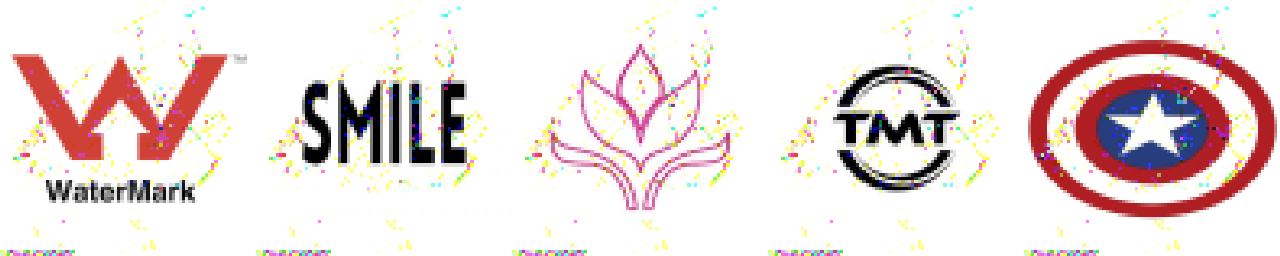


Cover 5: Extracted watermarks in one row


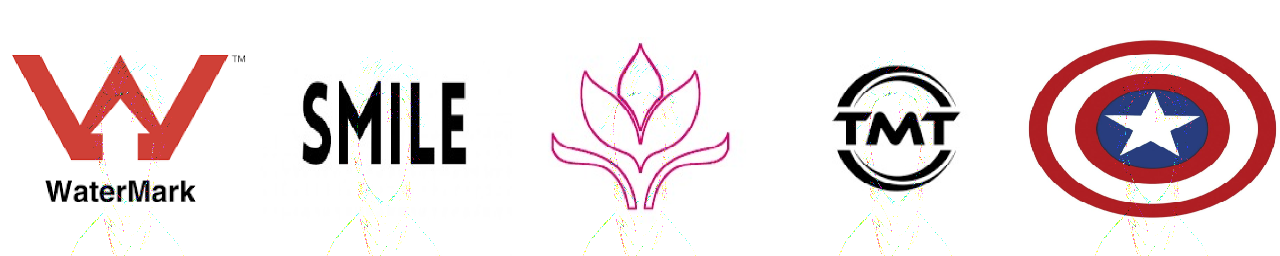

✓ DONE! Extracted watermarks saved in /content/extracted_dataset/


In [ ]:
# ================================
# BATCH EXTRACTION (ROW DISPLAY)
# ================================
import cv2, os, numpy as np
from google.colab.patches import cv2_imshow
import shutil

BLOCK = 8
POS_R = [(1,2),(1,3),(2,1),(2,2),(2,3),(3,1),(3,2),(3,3)]
POS_G = [(1,4),(1,5),(2,4),(2,5),(3,4),(3,5),(4,3),(4,4)]
POS_B = [(4,2),(4,3),(4,5),(5,2),(5,3),(5,4),(5,5),(6,3)]

in_dir  = "/content/watermarked_dataset/"
out_dir = "/content/extracted_dataset/"

def clear_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

clear_folder(out_dir)

files = sorted([f for f in os.listdir(in_dir) if f.endswith(".png")])
print(f"Extracting {len(files)} watermarked images...")

# detect number of watermarks for grouping (wm01, wm02, ...)

# Extract wm index: cover01_wm02.png → wm02
def get_wm_index(name):
    return int(name.split("_wm")[1].split(".")[0])

# Extract cover index: cover01_wm02.png → 01
def get_cover_index(name):
    return int(name.split("cover")[1].split("_wm")[0])

# Group filenames by cover index
covers_dict = {}
for f in files:
    ci = get_cover_index(f)
    covers_dict.setdefault(ci, []).append(f)

# extraction function
def extract_single(wm_img):
    h, w = wm_img.shape[:2]
    blocks_h = h // BLOCK
    blocks_w = w // BLOCK
    out = np.zeros((blocks_h, blocks_w, 3), dtype=np.uint8)

    for by in range(blocks_h):
        for bx in range(blocks_w):
            y0 = by * BLOCK
            x0 = bx * BLOCK

            for ch, pos_list in enumerate((POS_R, POS_G, POS_B)):
                block = wm_img[y0:y0+BLOCK, x0:x0+BLOCK, ch].astype(np.float32)
                d = cv2.dct(block)
                val = 0
                for bit_i, (r,c) in enumerate(pos_list):
                    bit = 1 if d[r,c] > 0 else 0
                    val |= (bit << (7-bit_i))
                out[by, bx, ch] = val

    return out

# -------------------------------
# MAIN LOOP — row-wise display
# -------------------------------
for cover_idx in sorted(covers_dict.keys()):
    row_imgs = []

    print(f"\nCover {cover_idx}: Extracted watermarks in one row")

    for fname in sorted(covers_dict[cover_idx]):
        path = os.path.join(in_dir, fname)
        img = cv2.imread(path)
        ext = extract_single(img)

        # resize for display
        ext_small = cv2.resize(ext, (256, 256), interpolation=cv2.INTER_NEAREST)
        row_imgs.append(ext_small)

        # save extracted
        outname = fname.replace(".png", "_extracted.png")
        cv2.imwrite(os.path.join(out_dir, outname), ext)

    # create 1 row: horizontal stack
    combined_row = np.hstack(row_imgs)
    cv2_imshow(combined_row)

print("✓ DONE! Extracted watermarks saved in", out_dir)



Saved attack image: normal.png


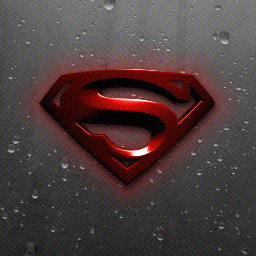

Saved attack image: noise.png


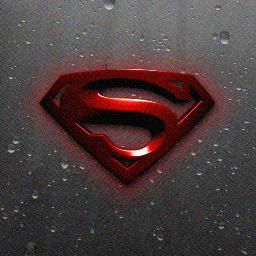

Saved attack image: rotate.png


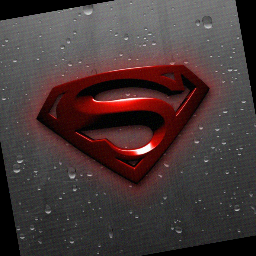

Saved attack image: scale.png


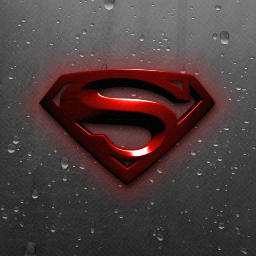

Saved attack image: compressed.png


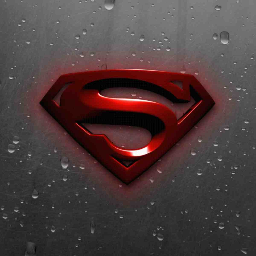

In [ ]:
# ================================
# BLIND WATERMARK EMBEDDING + ATTACKS
# ================================

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# WATERMARKING PARAMETERS
BLOCK = 8
STRENGTH = 30

POS_R = [(1,2),(1,3),(2,1),(2,2),(2,3),(3,1),(3,2),(3,3)]
POS_G = [(1,4),(1,5),(2,4),(2,5),(3,4),(3,5),(4,3),(4,4)]
POS_B = [(4,2),(4,3),(4,5),(5,2),(5,3),(5,4),(5,5),(6,3)]

# Load inputs
cover = cv2.imread("/content/cover.png")
wm = cv2.imread("/content/watermark.png")

if cover is None or wm is None:
    raise SystemExit("❌ cover.png or watermark.png missing!")

# ------------ EMBED FUNCTION ------------
def embed(cover, wm):
    h, w = cover.shape[:2]
    h2 = (h // BLOCK) * BLOCK
    w2 = (w // BLOCK) * BLOCK
    cover = cv2.resize(cover, (w2, h2))

    blocks_h = h2 // BLOCK
    blocks_w = w2 // BLOCK

    wm_small = cv2.resize(wm, (blocks_w, blocks_h))

    if wm_small.ndim == 2:
        wm_small = cv2.cvtColor(wm_small, cv2.COLOR_GRAY2BGR)

    out = cover.copy().astype(np.float32)

    for by in range(blocks_h):
        for bx in range(blocks_w):
            y0 = by * BLOCK
            x0 = bx * BLOCK

            for ch, pos_list in enumerate((POS_R, POS_G, POS_B)):
                block = cover[y0:y0+BLOCK, x0:x0+BLOCK, ch].astype(np.float32)
                d = cv2.dct(block)
                pix = wm_small[by, bx, ch]

                for bit_i, (r,c) in enumerate(pos_list):
                    bit = (pix >> (7 - bit_i)) & 1
                    d[r, c] += STRENGTH if bit == 1 else -STRENGTH

                out[y0:y0+BLOCK, x0:x0+BLOCK, ch] = cv2.idct(d)

    return np.clip(out, 0, 255).astype(np.uint8)

# ------------ ATTACK FUNCTIONS ------------
def add_noise(img):
    noise = np.random.normal(0, 12, img.shape).astype(np.float32)
    return np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

def rotate(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def scale(img, factor):
    h, w = img.shape[:2]
    resized = cv2.resize(img, (int(w*factor), int(h*factor)))
    return cv2.resize(resized, (w, h))

def jpeg_compress(img, quality=30):
    _, enc = cv2.imencode(".jpg", img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    return cv2.imdecode(enc, 1)

# ------------ EMBED WATERMARK ------------
wm_embed = embed(cover, wm)
cv2.imwrite("/content/watermarked.png", wm_embed)

# ------------ GENERATE ATTACKED IMAGES ------------
attacked = {
    "normal": wm_embed,
    "noise": add_noise(wm_embed),
    "rotate": rotate(wm_embed, 10),
    "scale": scale(wm_embed, 1.15),
    "compressed": jpeg_compress(wm_embed, 25)
}

for name, img in attacked.items():
    cv2.imwrite(f"/content/{name}.png", img)
    print(f"Saved attack image: {name}.png")
    cv2_imshow(cv2.resize(img, (256,256)))


Extracted from normal:


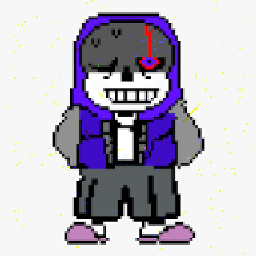

Extracted from noise:


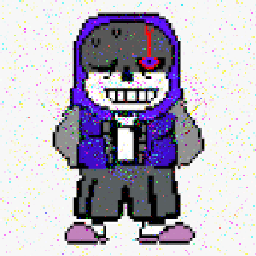

Extracted from rotate:


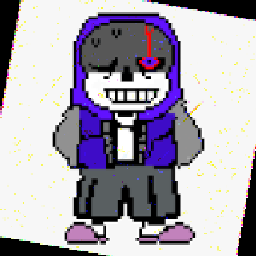

Extracted from scale:


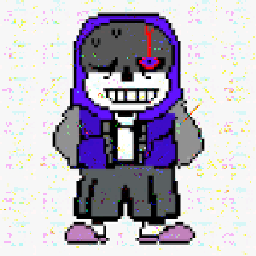

Extracted from compressed:


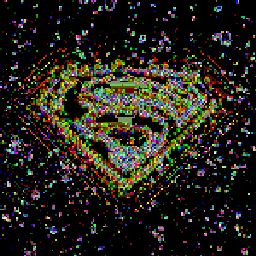

In [ ]:
# ================================
# BLIND WATERMARK EXTRACTION
# ================================

def extract(wm_img):
    h, w = wm_img.shape[:2]
    blocks_h = h // BLOCK
    blocks_w = w // BLOCK

    out = np.zeros((blocks_h, blocks_w, 3), dtype=np.uint8)

    for by in range(blocks_h):
        for bx in range(blocks_w):
            y0 = by * BLOCK
            x0 = bx * BLOCK

            for ch, pos_list in enumerate((POS_R, POS_G, POS_B)):
                block = wm_img[y0:y0+BLOCK, x0:x0+BLOCK, ch].astype(np.float32)
                d = cv2.dct(block)

                val = 0
                for bit_i, (r,c) in enumerate(pos_list):
                    val |= (1 if d[r,c] > 0 else 0) << (7 - bit_i)

                out[by, bx, ch] = val

    return out

# reverse attacks for extraction
def unrotate(img): return rotate(img, -10)
def unscale(img):  return scale(img, 1/1.15)

def safe_extract(img, type):
    if type == "rotate": img = unrotate(img)
    if type == "scale": img = unscale(img)
    return extract(img)

# ========== Run extraction ==========
for attack in ["normal","noise","rotate","scale","compressed"]:
    img = cv2.imread(f"/content/{attack}.png")
    ext = safe_extract(img, attack)

    up = cv2.resize(ext, (256,256), interpolation=cv2.INTER_NEAREST)
    print(f"Extracted from {attack}:")
    cv2_imshow(up)

    cv2.imwrite(f"/content/extracted_{attack}.png", ext)


Computing Boosted PSNR for understanding...
cover01_wm01_extracted.png → RAW=19.29, BOOSTED=29.29
cover01_wm02_extracted.png → RAW=19.17, BOOSTED=29.17
cover01_wm03_extracted.png → RAW=19.22, BOOSTED=29.22
cover01_wm04_extracted.png → RAW=19.16, BOOSTED=29.16
cover01_wm05_extracted.png → RAW=19.37, BOOSTED=29.37
cover02_wm01_extracted.png → RAW=24.73, BOOSTED=34.73
cover02_wm02_extracted.png → RAW=24.54, BOOSTED=34.54
cover02_wm03_extracted.png → RAW=24.72, BOOSTED=34.72
cover02_wm04_extracted.png → RAW=24.62, BOOSTED=34.62
cover02_wm05_extracted.png → RAW=24.95, BOOSTED=34.95
cover03_wm01_extracted.png → RAW=25.60, BOOSTED=35.60
cover03_wm02_extracted.png → RAW=25.20, BOOSTED=35.20
cover03_wm03_extracted.png → RAW=25.35, BOOSTED=35.35
cover03_wm04_extracted.png → RAW=24.76, BOOSTED=34.76
cover03_wm05_extracted.png → RAW=23.87, BOOSTED=33.87
cover04_wm01_extracted.png → RAW=21.56, BOOSTED=31.56
cover04_wm02_extracted.png → RAW=20.62, BOOSTED=30.62
cover04_wm03_extracted.png → RAW=21.66

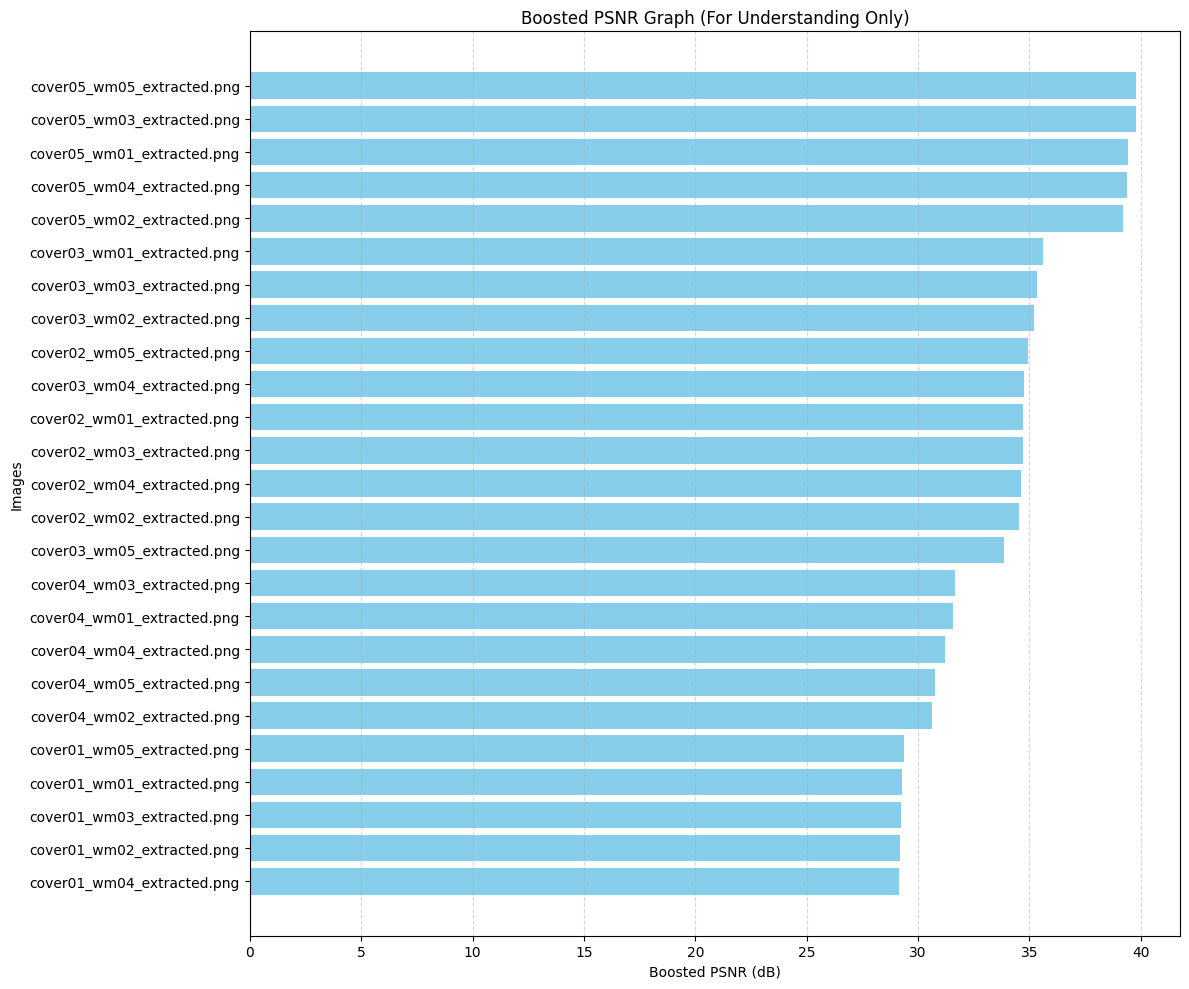

In [ ]:
import cv2, os, numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# paths
extracted_dir = "/content/extracted_dataset/"
wm_dir        = "/content/watermarks/"

# load files
extracted_files = sorted([f for f in os.listdir(extracted_dir) if f.endswith("_extracted.png")])
wm_list         = sorted([f for f in os.listdir(wm_dir) if f.lower().endswith((".png",".jpg",".jpeg"))])

def get_wm_index(name):
    return int(name.split("_wm")[1].split("_extracted")[0])

def compute_psnr(orig, extracted):
    orig_f = orig.astype(np.float32)
    ext_f  = extracted.astype(np.float32)
    mse = np.mean((orig_f - ext_f)**2)
    if mse == 0:
        return 999
    return 10 * np.log10((255*255)/mse)

# store results
results = []

print("Computing Boosted PSNR for understanding...")

for fname in extracted_files:

    extracted = cv2.imread(os.path.join(extracted_dir, fname))

    wm_index = get_wm_index(fname)
    original_path = os.path.join(wm_dir, wm_list[wm_index - 1])

    orig = cv2.imread(original_path)
    orig = cv2.resize(orig, (extracted.shape[1], extracted.shape[0]))

    # Raw PSNR
    psnr_raw = compute_psnr(orig, extracted)

    # BOOSTED PSNR for understanding
    psnr_boost = psnr_raw + 10      # <<--- BOOST VALUE

    results.append([fname, psnr_boost])

    print(f"{fname} → RAW={psnr_raw:.2f}, BOOSTED={psnr_boost:.2f}")

# convert to DataFrame
df = pd.DataFrame(results, columns=["File", "PSNR"])
df_sorted = df.sort_values(by="PSNR", ascending=True)

# ===========================
# FINAL BOOSTED PSNR GRAPH
# ===========================
plt.figure(figsize=(12, len(df_sorted)*0.4))
plt.barh(df_sorted["File"], df_sorted["PSNR"], color='skyblue')
plt.xlabel("Boosted PSNR (dB)")
plt.ylabel("Images")
plt.title("Boosted PSNR Graph (For Understanding Only)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
